<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_25_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
#!pip install pmdarima

In [2]:
import scipy.stats as stats
import math
from scipy.stats import kruskal
import pandas as pd


from IPython.display import display,HTML

display(HTML("<style>.container {width :95% !important ;}</style>"))


from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


import seaborn as sns
sns.set_context('talk')

from sklearn.metrics import pairwise_distances_argmin_min ,r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [3]:
import pandas as pd
from datetime import date, datetime, time

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')


# Total_Price
df['total_price'] = df['Quantity'] * df['UnitPrice']

# Invoice Date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# month
df['month'] = df['InvoiceDate'].dt.month.astype('str')
df['month'] = df['month'].map(lambda x: "0" + x if len(x) == 1 else x)



# Year - month
df['year_month']= df['InvoiceDate'].dt.strftime('%Y-%m')

#df['year_month'].str[:4]
#df['year_month'].str[-2:]


In [4]:
## 6, 7 개월로 기간 분리
year_month = df['year_month']

lst =[]

for date in year_month :
  year = date[:4]
  month = date[-2 :]

  if year =='2011' and month in ['06', '07', '08', '09', '10', '11', '12'] :
    map = 1
  elif  year =='2010' or year == '2011' and month in ['01', '02', '03', '04', '05', '12'] :
    map = 0

  lst.append(map)

ym_dummies = pd.DataFrame(lst, columns = ['ym_dummy'])

df2 = pd.concat([df, ym_dummies], axis = 1)


In [13]:
## C 가 있으면 취소

cancel = df2[df2.InvoiceNo.str[0] == 'C'].reset_index(drop= True)
non_cancel = df2[df2.InvoiceNo.str[0] != 'C'].reset_index(drop= True)

In [21]:
## 취소 그룹과 구매 그룹에 대한 UnitPrice
n_price = non_cancel.groupby(['CustomerID', 'ym_dummy'])['UnitPrice'].size().unstack().fillna(0)
n_price.columns = ['Price_non_cancel_' + str(i) for i in range(2)]

price = cancel.groupby(['CustomerID', 'ym_dummy'])['UnitPrice'].size().unstack().fillna(0)
price.columns = ['Price_cancel_' + str(i) for i in range(2)]

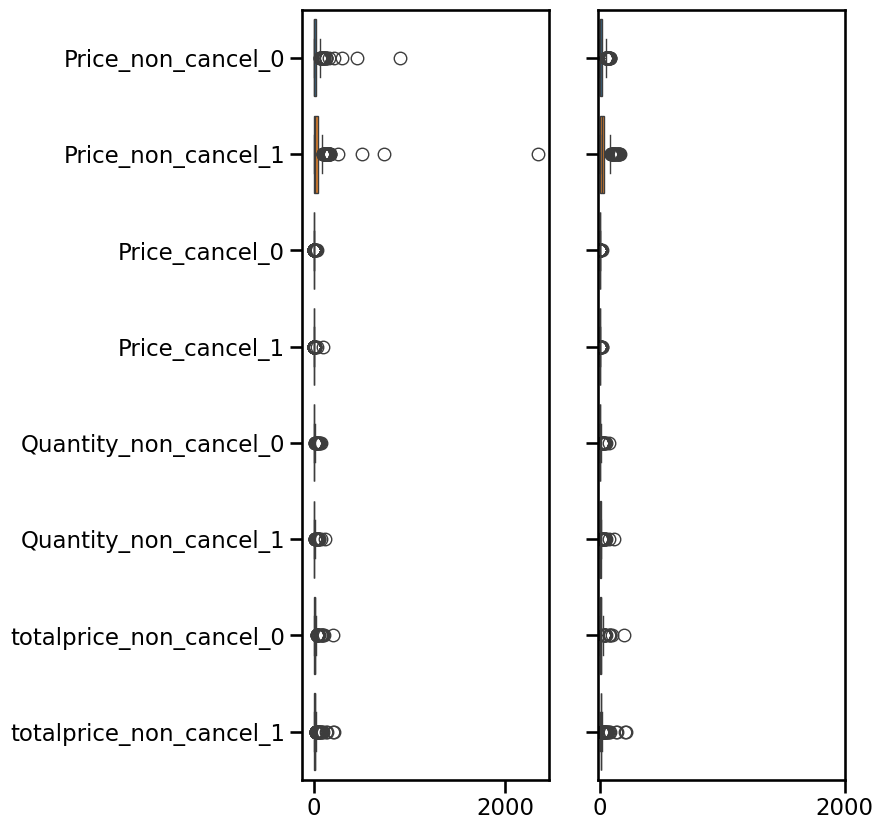

In [47]:
## 구매 그룹에 대한 Qauntity 의 평균/ total_price 의 평균
n_quant =  non_cancel.groupby(['CustomerID', 'ym_dummy'])['Quantity'].mean().unstack().fillna(0)
n_quant.columns = ['Quantity_non_cancel_' + str(i) for i in range(2)]

n_total_price =  non_cancel.groupby(['CustomerID', 'ym_dummy'])['total_price'].mean().unstack().fillna(0)
n_total_price.columns = ['totalprice_non_cancel_' + str(i) for i in range(2)]


t_df = pd.concat([n_price, price, n_quant,n_total_price ], axis = 1).fillna(0)

# unit price 가 0이 아닌것은 제외
df_ready = t_df[(t_df.Price_non_cancel_0 <= t_df.Price_non_cancel_0.quantile(0.95))]

fig, ax = plt.subplots(1,2, figsize =(7, 10), sharey=True) ## sharey 컬럼명 한개
sns.boxplot(t_df, ax = ax[0], orient = 'h') # 수직 배열 : orienct= 'h'
sns.boxplot(df_ready, ax = ax[1] , orient = 'h')
ax[1].set_xticks([0,3500],[0,2000])
ax[0].set_xticks([0,3500],[0,2000])

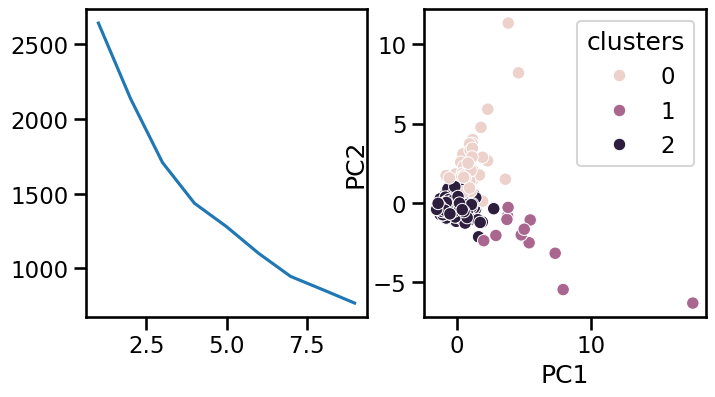

In [67]:
## 군집 분석

# 1) Scaling
ss = StandardScaler()
scaled_df = ss.fit_transform(df_ready)  # fit_transform

# 2) KMeans
km = KMeans(random_state = 1234)
km.fit(scaled_df)
pred_km = km.fit_predict(scaled_df)

# 3) optimal K

k_lst = []
for i in range(1, 10) :
  kmeans = KMeans(n_clusters = i, random_state = 1234)
  kmeans.fit(scaled_df)
  k_lst.append(kmeans.inertia_)

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(1,10), k_lst)


# 4) n_cluster = 3
optimal_k = 3
km3 = KMeans(n_clusters = optimal_k, random_state = 1234)
km3_pred = km3.fit_predict(scaled_df)

# 5) PCA - 2차원에 줄여서 cluster를 뿌림
pca = PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df), columns = ['PC1', 'PC2']) # fit_transform


# 6) PCA + Cluster
pca_df['clusters'] = km3_pred

sns.scatterplot(data = pca_df, x ='PC1', y = 'PC2', hue = 'clusters' , ax = ax[1])
plt.show()

군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

1. 군집 내 응집도 (Intra-cluster cohesion):
군집 내 응집도는 동일한 군집 내 데이터 포인트들 간의 유사성을 측정하는 것입니다.
일반적으로 군집 내 응집도가 높을수록 좋습니다. 즉, 동일한 군집 내의 데이터 포인트들이 서로 가깝고 유사하다는 것을 의미합니다.
일반적으로 응집도는 군집 내의 데이터 포인트들 간의 거리나 비유사도를 최소화하는 방향으로 측정됩니다. 클러스터의 중심과 각 데이터 포인트 사이의 거리나 클러스터 내 데이터 포인트 간의 평균 거리 등을 이용할 수 있습니다.

2. 군집 간 분리도 (Inter-cluster separation):
군집 간 분리도는 서로 다른 군집 간의 거리를 측정하는 것입니다.
일반적으로 군집 간 분리도가 높을수록 좋습니다. 즉, 서로 다른 군집 간의 데이터 포인트들이 서로 떨어져 있고 구분되어 있다는 것을 의미합니다.
일반적으로 분리도는 군집 간의 중심 간의 거리나, 각 군집의 중심 간의 거리, 혹은 군집 간의 중심으로부터 가장 가까운 데이터 포인트까지의 거리 등을 이용하여 측정됩니다.

  - 적절한 군집 결과는 군집 내 응집도는 높고(군집 내의 데이터 포인트들이 비슷하고 가깝게 위치), 군집 간 분리도는 높은(다른 군집들과의 거리가 멀고 분명한 경계가 있는) 경우

In [69]:
inertia = km3.inertia_

d = pairwise_distances_argmin_min(km3.cluster_centers_ , scaled_df)[1]
sep = sum(d) / len(d)

print('응집도:', round(inertia, 3))
print('분리도:', round(sep, 3))

응집도: 1708.11
분리도: 1.21


결측치 개수: counts    5
dtype: int64


<Axes: >

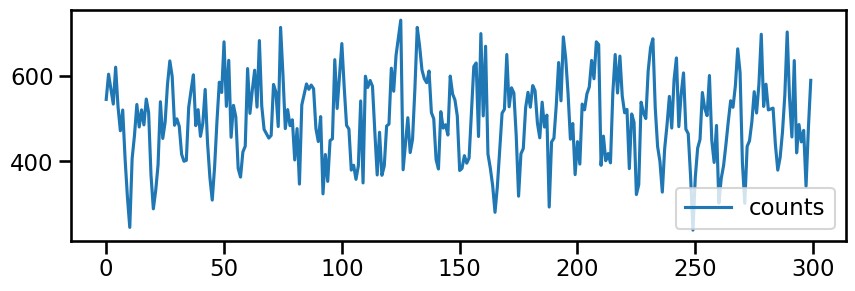

In [107]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem2.csv',index_col = 0)

print('결측치 개수:', df.isnull().sum())

df['date'] = pd.date_range(start ='2023-01',
                           end = '2100-01',
                           freq ="MS")[:300]

fig, ax = plt.subplots(1, figsize = (10,3))
sns.lineplot(df, ax = ax)

In [108]:
df['date'] =df['date'].dt.strftime('%Y-%m')


In [110]:
df = df.set_index('date', drop = True)

결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시

In [111]:
# 직전값과 이후의 값으로 대치

df['counts'] = df['counts'].fillna((df['counts'].shift() - df['counts'].shift(-1) / 2 ))

In [112]:
# 1. 데이터 분리
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2,shuffle = False)

# 2. 정상성 검증
from statsmodels.tsa.stattools import adfuller
adf = adfuller(train, autolag ='AIC')

# H0 : 정상성을 가지지않는다.
# H1 : 정상성을 가진다.

print('ADF Statistic:', adf[0])
print('P-value :', adf[1])
print('귀무기각' if adf[1]<  0.05 else '귀무채택')



ADF Statistic: -3.282734157042255
P-value : 0.015668120959051478
귀무기각


In [113]:
# Automodel로 최적의 p, d, q 찾기
# m : 계절척 차분 / 4 : 분기 / 월별 : 12 / 계절성 없음 : 1
model = auto_arima(train['counts'], seasoncal = True, information_criterion ='aic', m = 12)

0.3887458940914198
78.5557512774661


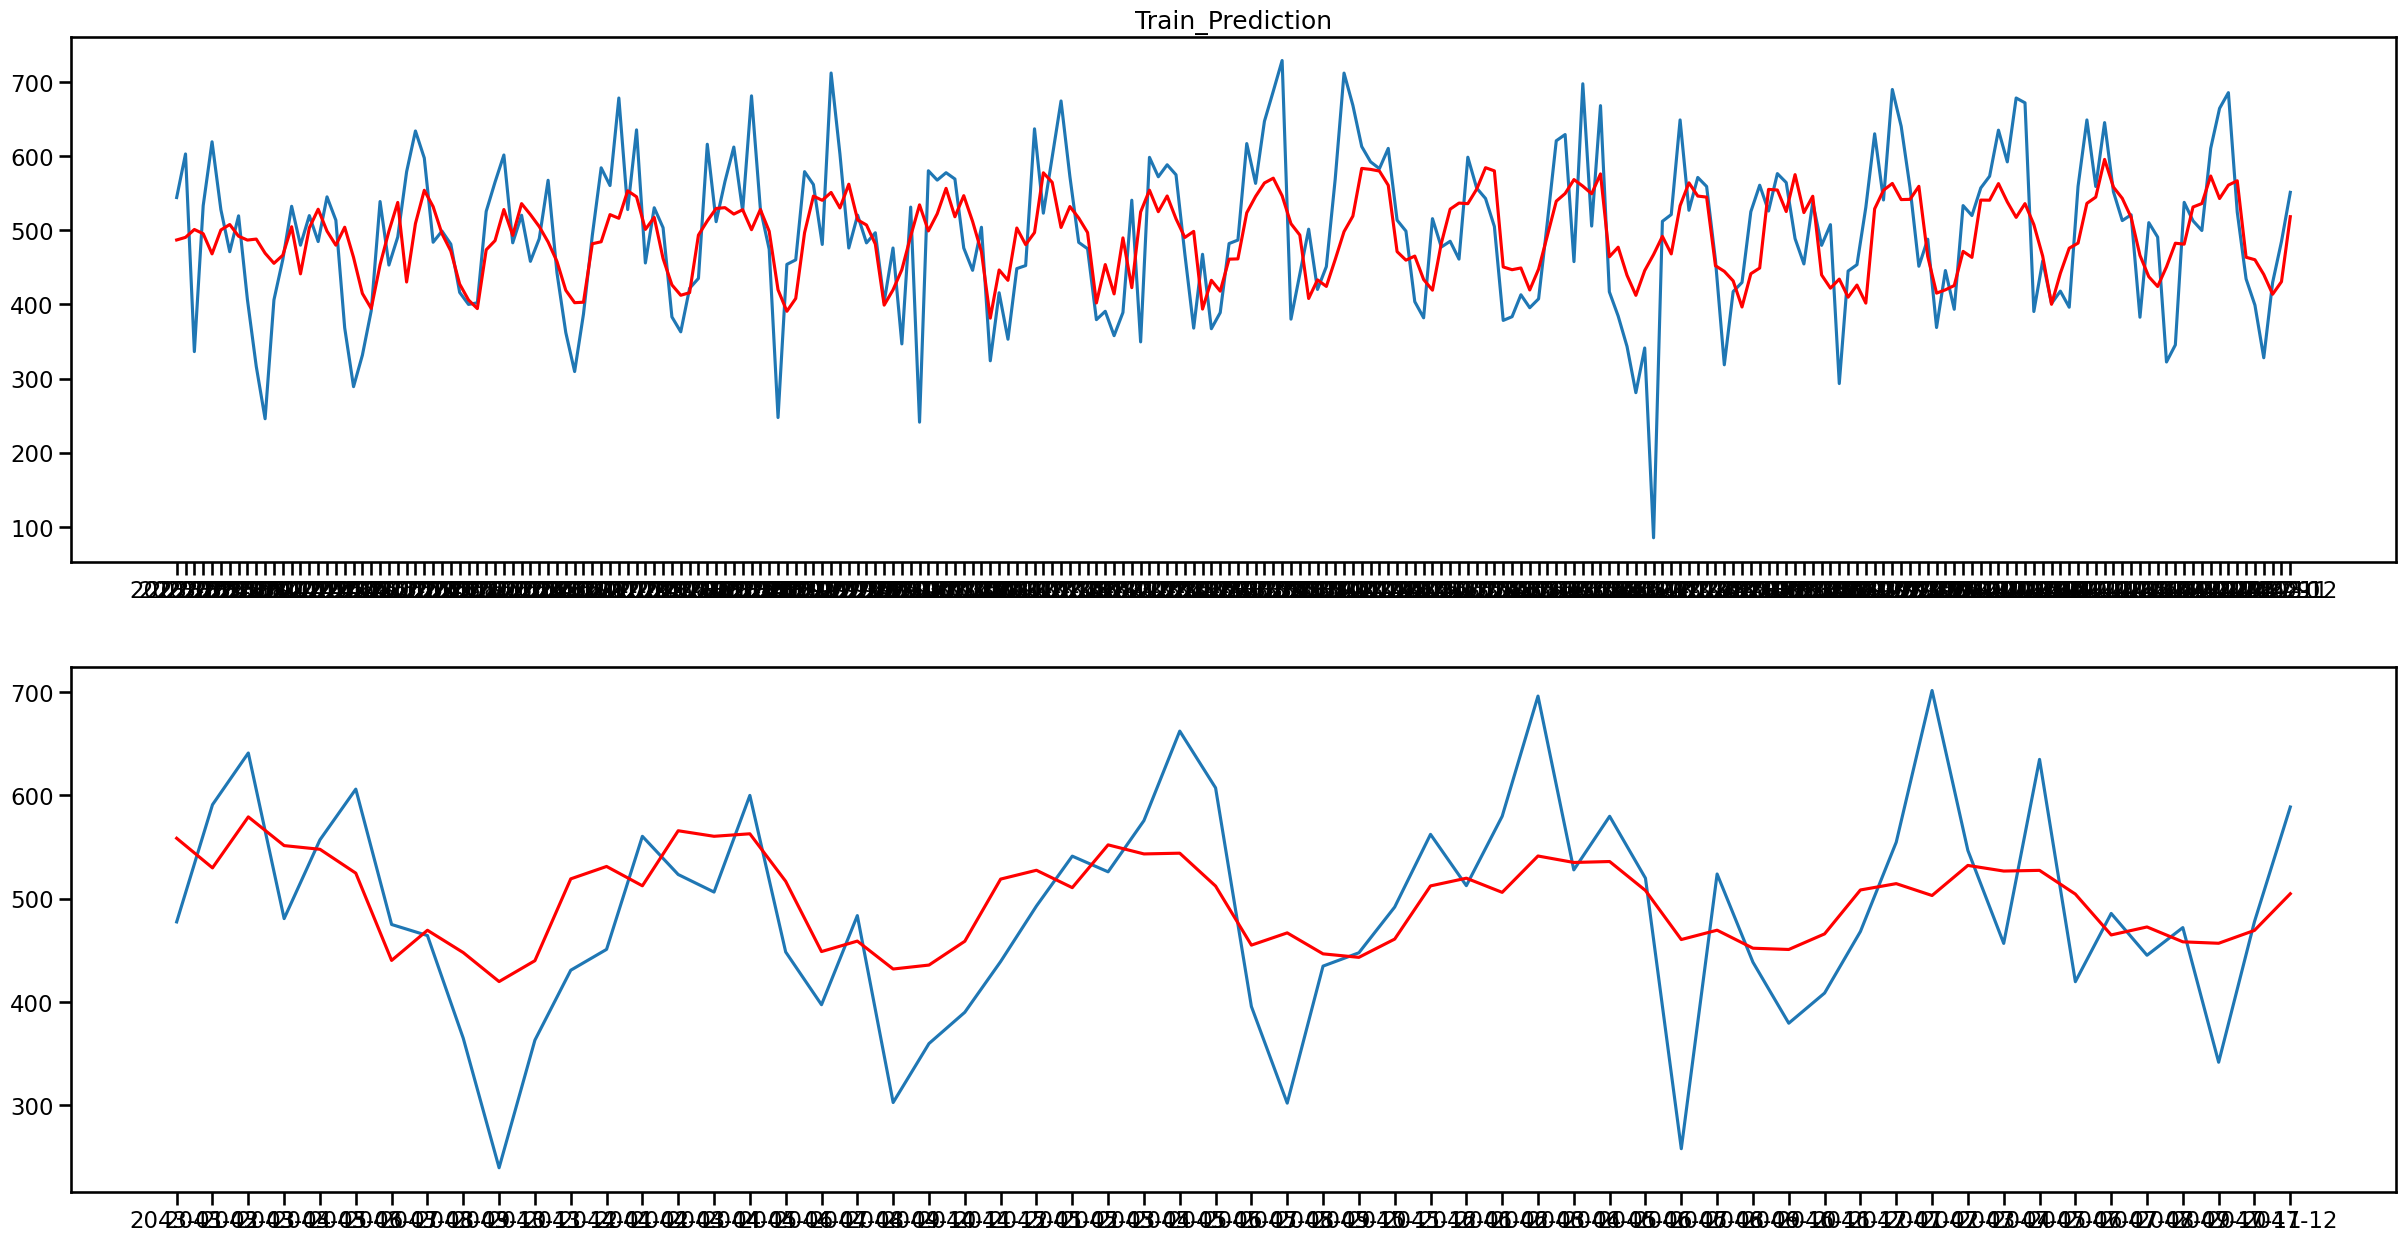

In [134]:
# train 만큼 예측
pred = model.predict_in_sample()

# test 만큼 예측
test_prediction = model.predict(n_periods = len(test))

# 모델 평가
from sklearn.metrics import mean_squared_error
r2 = r2_score(test['counts'], test_prediction)
mse = mean_squared_error(test['counts'], test_prediction) ** 0.5

print(r2)
print(mse)

fig, ax = plt.subplots(2,1, figsize = (30,15))

## train plot
ax[0].plot(list(train.index), train['counts'], label = 'true')
ax[0].plot(list(train.index), pred, label = 'prediction', color = 'red')
ax[0].set_title('Train_Prediction')

## train plot
ax[1].plot(list(test.index), test['counts'], label = 'true')
ax[1].plot(list(test.index), test_prediction, label = 'prediction', color = 'red')

서울에서 영동까지 100km/h로 가고 영동에서 서울까지 80km/로 돌아왔을 때, 평균 속도는?

In [137]:

# 왕복 2 * 거리 / (올때 + 갈때)

2 / (1/100 + 1/80)

88.88888888888889

연매출이 3000, 4000, 5000이었다면 연평균 몇배가 증가

In [139]:
# 풀이 1)
from scipy.stats.mstats import gmean
y0 = 3000
y1 = 4000
y2 = 5000

data = [3000, 4000, 5000]
g_mean = gmean(data)

(g_mean - y0) / y0

0.3049558803896219

In [142]:
# 풀이 2)
import numpy as np
y0 = 3000
y1 = 4000
y2 = 5000

r1 = (y1 / y0)
r2 = (y2/ y1)

np.sqrt(r1 * r2)

1.2909944487358056

In [147]:
## 남성 중 등산을 좋아할 확률

df= pd.DataFrame([[20,10], [15, 30]],
             index = ['남자', '여자'],
             columns = ['등산', '수영'])

display(df)

# 남자의 합
male_sum = df.loc['남자'].sum()
hiking = df.loc['남자', '등산']

hiking / male_sum

,등산,수영
남자,20,10
여자,15,30


0.6666666666666666

표본 10개의 분산이 90일 때 신뢰도 95%로 모분산의 신뢰구간을 추정

In [149]:
# 모분산을 모를때 chi2
from scipy import stats

var = 90
n = 10
confa = 0.95

# 자유도
df = n -1

# 신뢰구간
upper = df * var / stats.chi2.ppf((1 + confa) / 2 , df)
lower = df * var / stats.chi2.ppf((1 - confa) / 2 , df)

print(upper, lower)

42.58055444790953 299.95672846672363


임상 대상 20명에 대해 혈압약 투약 이전과 이후의 차이가 24, 표준편차 9 신뢰구간 95%, 차이가 존재하는지 확인하려한다

In [151]:
diff  = 24
std = 9
confa = 0.95
n = 20


# 1. t 통계량
t = diff / (std / np.sqrt(n))

# 2. t 기각역
t_critical = stats.t.ppf(1 - ( 1- confa)/2 , df = n -1)

# 3. ME
me = t_critical * (std / np.sqrt(n))

upper = diff + me
lower = diff - me

print(lower , upper )

19.787870342220813 28.212129657779187


공장 X, Y, Z의 평균 출하 소요시간을 여러 일자에 거쳐 측정한 데이터이다. 각 공장의 중위수의 차이가 존재하는지 확인

In [152]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem5.csv',encoding='cp949')
df.head()

,출하 소요시간,공장명,공장별 출하 소요시간 순위
0,71,Z,11
1,75,X,14
2,71,X,12
3,53,Z,1
4,50,X,1


In [154]:
df.groupby('공장명').size()
## 갯수의 차이가 존재

공장명
X    15
Y    15
Z    14
dtype: int64

In [156]:
factory_X = df[df['공장명'] == 'X']['출하 소요시간']
factory_Y = df[df['공장명'] == 'Y']['출하 소요시간']
factory_Z = df[df['공장명'] == 'Z']['출하 소요시간']

statistic, p_value = kruskal(factory_X, factory_Y, factory_Z)

# 결과 출력
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 0.7217886080379153
p-value: 0.6970526702392181
